In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
from astropy.convolution import Gaussian1DKernel
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam
from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    #catalog = astrodendro.ppv_catalog(d, metadata)
    center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        for lmi in range(len(I[0])):
            NansNE=0
            NansSE=0
            NansNW=0
            NansSW=0
            Length = 10
            #I[1][lmi+10]>
            for lmj in range(Length):
                #Check four 45 degree prongs from each point and see if they have at least 7 nans in 10 pixels. If that happens its too close to the boundary
                if(sliced[I[1][lmi]+lmj,I[2][lmi]-lmj]>0 or sliced[I[1][lmi]+lmj,I[2][lmi]-lmj]<0 ):
                    pass
                else:
                    NansSE+=1
                if(sliced[I[1][lmi]-lmj,I[2][lmi]-lmj]>0 or sliced[I[1][lmi]-lmj,I[2][lmi]-lmj]<0 ):
                    pass
                else:
                    NansSW+=1
                if(sliced[I[1][lmi]-lmj,I[2][lmi]+lmj]>0 or sliced[I[1][lmi]-lmj,I[2][lmi]+lmj]<0 ):
                    pass
                else:
                    NansNW+=1
                if(sliced[I[1][lmi]+lmj,I[2][lmi]+lmj]>0 or sliced[I[1][lmi]+lmj,I[2][lmi]+lmj]<0 ):
                    pass
                else:
                    NansNE+=1
            if(NansNE>Length-3 or NansNW>Length-3 or NansSE>Length-3 or NansSW>Length-3):
                Cont=False
                break

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if( (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>.5 and (float(s.v_rms/u.km*u.s))>.2):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
                
                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*3.5/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                
                
                #print(catalog[t.idx]['radius']*np.pi/180*3.5/u.deg,s.radius*np.pi/180*3.5/u.deg)
                #print(catalog[t.idx]['v_rms'],(float(s.v_rms/u.km*u.s)))
                
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*3.5*10**6/u.deg#pc dist from barycenter
                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    
                    
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L



#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]

    
def Read_Clusters(FileName):
    
    sh= len(np.genfromtxt(FileName,usecols=0))
    Data=[]
    for lmi in range(50):
        try:
            Data.append(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m")))
            #print(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m"),skip_header=1))
        except:
            pass
    return Data
def Find_Clusters_NGC(Data):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
            
    return IDs,RAs,Decs,R_deconv
#Take the cont in Jy and find the HWHM from the structures in the catalog
def Find_Clusters(Data,wcs,Cont_Data,header):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
        if "herschel_column" in Data[lmi]: 
            CD= (Data[lmi][1:9999])#pc
            
        if "flux_integrated" in Data[lmi]: 
            Flux_1p3mm= Data[lmi][1:9999]#pc
    #remove nan 
    for lmii in range(len(CD)):
        try:
            if CD[lmii]=='np.nan':
                CD= np.delete(CD, lmii)
                Flux_1p3mm= np.delete(Flux_1p3mm, lmii)
                IDs= np.delete(IDs, lmii)
                glats= np.delete(glats, lmii)
                glons= np.delete(glons, lmii)
                
        except:
            CD = np.array(CD,dtype=type(1.2**5))#float
            break
    glats_New=[]
    glons_New=[]
    CDs_New=[]
    IDs_New=[]
    Flux_1p3mm_New=[]

    #print(CD,sorted(CD),type(CD),type(CD[0]))
    nth = sorted(CD)[len(CD)-34]#34 most dense leaves
    #print(nth,"A",CD,sorted(CD))
    for lmj in range(len(CD)):
        if CD[lmj]>nth:
            glats_New.append(glats[lmj])
            glons_New.append(glons[lmj])
            CDs_New.append(CD[lmj])
            IDs_New.append(int(IDs[lmj]))
            Flux_1p3mm_New.append(Flux_1p3mm[lmj])
    HWHM_rad = []      
    #print(Flux_1p3mm_New,glats_New,glons_New,CDs_New,IDs_New)
    for lmi in range(len(CDs_New)):
        glat = glats_New[lmi]
        glon = glons_New[lmi]
        Flux = float(Flux_1p3mm_New[lmi])#INtegerated flux in jy
        
        Circle_R = 0
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        
        while(True):
            Circle_R += .01
            #pixels=[(p1,p2)]
            pixels=[(p2,p1)]#Goes lat then long for the cont data
            #print(p1,p2)
            #print(np.shape(Cont_Data[p2-50:p2+50]))
            #print(np.shape(Cont_Data[50,p1-50:p1+50]))
            for lmii in range(np.shape(Cont_Data[p2-50:p2+50])[0]):
                for lmjj in range(np.shape(Cont_Data[p2-50+lmii,p1-50:p1+50])[0]):
                    #Find pixels within the circle around the center (excude the center since its there already)
                    #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                    if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                        pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
                        
            
            
            sum_flux=0
            for lmkk in range(len(pixels)):
                sum_flux += (Cont_Data[pixels[lmkk]])
            #print(p1,p2,glat,glon,np.shape(Cont_Data),pixels,Cont_Data[pixels[0]],Flux,sum_flux,Circle_R)
            if sum_flux>Flux/2:
                HWHM_rad.append(Circle_R)#Pc
                break
                
    return HWHM_rad,CDs_New,glons_New,glats_New,IDs_New

#Return masked data around clusters or one pc around clusters
def Mask_Clusters_NGC(HWHM,wcs,header,unmasked_data,ras,decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        ra = ras[lmi]
        dec = decs[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 3.5*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(str(ra),str(dec), frame='icrs')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)


# Part 1: Updates

In [ ]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy

'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

# Part 2: Reprojection

In [ ]:

#Just Using CO 3-2 right now
files = ["NGC253.band7.TP+12m-mid+12m-high.CO_3-2.image.pbcor.fits"]
#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,300):
    
    sc = SpectralCube.read(files[0])  
    
    if(i*30>len(sc)):
        print("End Loop at",i)
        break

    sc = sc[i*30:i*30+30,50:np.shape(sc)[1]-50,50:np.shape(sc)[2]-50]# Make a subcube
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    del sc

    sc = sc_kms.spectral_slab(0. *u.km / u.s, 501. *u.km / u.s)  # Crop out velocities we don't care about    
    del sc_kms
    sc.allow_huge_operations=True    
    HI = sc.header
    Nres=4.3*u.pc
    dist=3.5*10**6
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
    sc.allow_huge_operations=True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    

   
    gal="NGC253"
    
    
    
    #Now that we have a circular beam, this can be done easily:
    #use some trig to make a rectangle at 33 deg, and allow pixels inside it.
    if(gal == 'NGC253'):

        cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
        cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
        #center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
        center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
        
        center_ra_pix,center_dec_pix = [int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])]
        PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*3.5*10**6))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*3.5*10**6))/2]
        print(center_ra_pix,center_dec_pix)
        pixels = np.zeros(np.shape(sc))           
        for lmi in range(np.shape(sc)[0]):
            for lmj in range(np.shape(sc)[1]):
                for lmk in range(np.shape(sc)[2]):
                    hypo = np.sqrt(((lmj-center_dec_pix)**2) + (lmk-center_ra_pix)**2)

                    if (lmj-center_dec_pix!=0):
                        ang = np.arctan(abs(lmk-center_ra_pix)/abs(lmj-center_dec_pix))#Find angle to the center
                    else:
                        ang = np.pi/2
                    if(lmk>center_ra_pix and lmj>center_dec_pix):
                        ang*=-1
                        #print("A",lmk,lmj,ang)
                    elif(lmk<center_ra_pix and lmj<center_dec_pix):
                        ang*=-1
                        #print("B",lmk,lmj,ang)
                    elif(lmk>center_ra_pix and lmj<center_dec_pix):
                        if ang >57*np.pi/180:
                            #print("C",lmk,lmj,ang)
                            
                            ang= -33*np.pi/180+147*np.pi/180-ang#coming from the opposite end of the ra axis now, but projecting still to 33 deg from north.
                            
                            #print(ang,hypo*np.cos(abs((33*np.pi/180)+ang)),hypo*np.sin(abs((33*np.pi/180)+ang)))
                        else:
                            #print(ang,hypo*np.cos(abs((33*np.pi/180)+ang)),hypo*np.sin(abs((33*np.pi/180)+ang)))
                            #print("D",lmk,lmj,ang)
                            pass
                            
                        
                    up_pixels = abs(hypo*np.cos(abs((33*np.pi/180)+ang)))#Should not be over the fov in the upwards direction (relative to 0 degrees)
                    side_pixels = abs(hypo*np.sin(abs((33*np.pi/180)+ang)))#Should not be over the fov in the side-side direction (relative to 0 degrees)

                    if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                        pixels[lmi][lmj][lmk] = 1#good
                #print(up_pixels,side_pixels ,PixFov)
                #print(    center_ra_pix,    center_dec_pix,PixFov,side_pixels,up_pixels,ang,lmi,ggg,fff,pixels[lmi][ggg][fff])
        #print(pixels)
        bp = np.where(pixels!=1)
        #Mask teh pixels outside the fov
        scCopy = sc.hdu
        #sc.hdu.data[bp]=9999#np.nan
        scCopy.data[bp]=np.nan
        sc = SpectralCube.read(scCopy)
        del scCopy

    
    reheader = sc.header
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        pix_x    = (res/5.).to(u.degree).value
        origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        
    else:
        pix_x    = -1.*(res/5.).to(u.degree).value
        origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        
    if sc.header['cdelt2']>0:
        pix_y    = (res/5.).to(u.degree).value
        origin_y = sc.latitude_extrema[0].to(u.degree).value
    else:
        pix_y    = -1.*(res/5.).to(u.degree).value
        origin_y = sc.latitude_extrema[1].to(u.degree).value
        
    if gal=='NGC253':
        npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
        npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        
    elif gal=='GC':
        npix_x   = int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        
    #Correct the header to the expected pixels for the new res
    
    sc.write("test1.fits",overwrite=True)
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test2.fits",overwrite=True)
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test3.fits",overwrite=True)
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test4.fits",overwrite=True)
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass

    # regrid cube to target pixel size
    sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    sc_K_kms.write("test5.fits",overwrite=True)
    new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
    new.allow_huge_operations=True
    new = new*sc_K_kms[0][0][0].unit
    #do this because scs dont like being modified
    del sc_K_kms
    sc_K_kms = new
    del new
    
    print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
    del sc
    vel = np.arange(0,501,3.3)*u.km/u.s
    NGC_CO_J3_2 = sc_K_kms
    del sc_K_kms
    NGC_CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    NGC_CO_J3_2.write(("4.3pc_beam_"+str(i)+'_NGC_CO_J3_2_70x360pc.fits'),overwrite=True)      
    del NGC_CO_J3_2

        



print("done")         

In [ ]:
#Splice CO


vel = np.arange(0,501,3.3)*u.km/u.s    
for i in range(0,9):
    sc=SpectralCube.read(("4.3pc_beam_"+str(i)+'_NGC_CO_J3_2_70x360pc.fits'))      
    print(sc.mask,type(sc.mask))
        
    if i==0:
        reheader = sc.header
        rewcs = sc.wcs
    
    
    print(type(sc))
    if i ==0:
        scW=SpectralCube.read(("4.3pc_beam_"+str(i)+'_NGC_CO_J3_2_70x360pc.fits'))      
        mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
    else:


        if i ==1:
            scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
            print(type(scW))
            mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
        else:
            scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
            mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
        
            
    print(np.shape(scW))

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-0,501,3.3)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-3.3**2))
scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits",overwrite=True)
#scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)


print("done")         

In [ ]:
#Fix reprojected repeated pixels

pathCO = "NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"
#pathCO = "NGC_Spliced_Reprojected_Whole_CO_32.fits"
sc = SpectralCube.read(pathCO).with_spectral_unit(u.km/u.s,velocity_convention="radio")
sp=0
for lmi in range(len(sc)):
    #Check to see if the slice has been repeated by the interpolation function
    if(np.round(np.nanmean(sc[lmi].hdu.data),5)==np.round(np.nanmean(sc[lmi+1].hdu.data),5)):
        
        sp = lmi+1
    else:
        print("A")
        print(lmi,np.nanmean(sc[lmi].hdu.data),np.nanmean(sc[lmi+1].hdu.data))
        break
l = len(sc)-1
ep=l
for lmi in range(l):

    if(np.round(np.nanmean(sc[l-lmi].hdu.data),5)==np.round(np.nanmean(sc[l-lmi-1].hdu.data),5)):
        ep = l-lmi-1
        
    else:
        print("B",lmi)
        break
        
print(sp,ep)#These are the start and stop slices where the actual unique data resides

sc.allow_huge_operations=True
sc = sc[sp:ep]

sc.write(("Cropped_"+pathCO),overwrite=True)
print("Done")

In [ ]:
#Get right size

path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
datn = Qp.hdu.data
sx,sy,ex,ey=0,0,0,0
for lmi in range(np.shape(datn[0,:,:])[0]):
    
    if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
        print("F",lmi)
        break
    for lmj in range(np.shape(datn[0,:,:])[1]):
        
        if(sx==0):            
            if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                sx=lmi
                
                
        if(sy==0):
            if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                sy=lmj
                
        if(ex==0):
            if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                ex=np.shape(datn[0,:,:])[0]-lmi-1
                
        if(ey==0):
            if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                ey=np.shape(datn[0,:,:])[1]-lmj-1
                
        if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
            break
print(sx,ex,sy,ey)
Q = Qp[:,sx:ex,sy:ey]
Qd=Q
datn=Qd.hdu.data

zeros=((datn[:,:,:]==0))

bp = np.where(zeros)
print(zeros)

datn[bp]=np.nan
print(datn[bp])

Qp = SpectralCube(data=datn,wcs = Qp.wcs,header=Qp.header)

Qd.write(("Fully_"+path),overwrite=True)

# Part 4: Dendograms

In [ ]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

In [ ]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level = "All"

try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,50:1200,0:1370-50]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,50:1200,0:1370-50]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))

m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K
if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="None (m)"):
    datn[np.where(datn<-m)]=np.nan
if(Abs_Level=="None All Channels"):
    for lmi in range(len(datn)):
        bpP = np.where(datn[lmi]<-m)
            for lmj in range(len(datn)):
                datn[lmj,bpP]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


In [ ]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level = "None"

try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,50:1200,0:1370-50]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,50:1200,0:1370-50]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))

m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K
if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


In [ ]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level = "No Clusters"

try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,50:1200,0:1370-50]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,50:1200,0:1370-50]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))

m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K
if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


In [ ]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level = "None (m)"

try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,50:1200,0:1370-50]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,50:1200,0:1370-50]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))

m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K
if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="None (m)"):
    datn[np.where(datn<-m)]=np.nan
if(Abs_Level=="None All Channels"):
    for lmi in range(len(datn)):
        bpP = np.where(datn[lmi]<-3*m)
        for lmj in range(len(datn)):
            datn[lmj][bpP]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
if(Abs_Level=="None (m)"):
    Suffix='None_m'
if(Abs_Level=="None All Channels"):
    Suffix='None_All_Channels'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


In [ ]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level = "None All Channels"

try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,50:1200,0:1370-50]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,50:1200,0:1370-50]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))

m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K
if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="None (m)"):
    datn[np.where(datn<-m)]=np.nan
if(Abs_Level=="None All Channels"):
    for lmi in range(len(datn)):
        bpP = np.where(datn[lmi]<-3*m)
        for lmj in range(len(datn)):
            datn[lmj][bpP]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)

##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
if(Abs_Level=="None (m)"):
    Suffix='None_m'
if(Abs_Level=="None All Channels"):
    Suffix='None_All_Channels'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


CO 3-2_Abs_New_4.3
5.999999999999992e-07 MPC per pix
0.15980268450849897 Unmatched Noise (K)
0
0.15980268450849897 Unmatched Noise (K)
1
0.15980268450849897 Unmatched Noise (K)
2
0.15980268450849897 Unmatched Noise (K)
3
L () (146, 842, 1080) (146, 842, 1080)
0.15980268450849897 Unmatched Noise (K)
4
L () (146, 842, 1080) (146, 842, 1080)
0.15980268450849897 Unmatched Noise (K)
5
L () (146, 842, 1080) (146, 842, 1080)
0.15980268450849897 Unmatched Noise (K)
6
L () (146, 842, 1080) (146, 842, 1080)
0.15980268450849897 Unmatched Noise (K)
7
L () (146, 842, 1080) (146, 842, 1080)


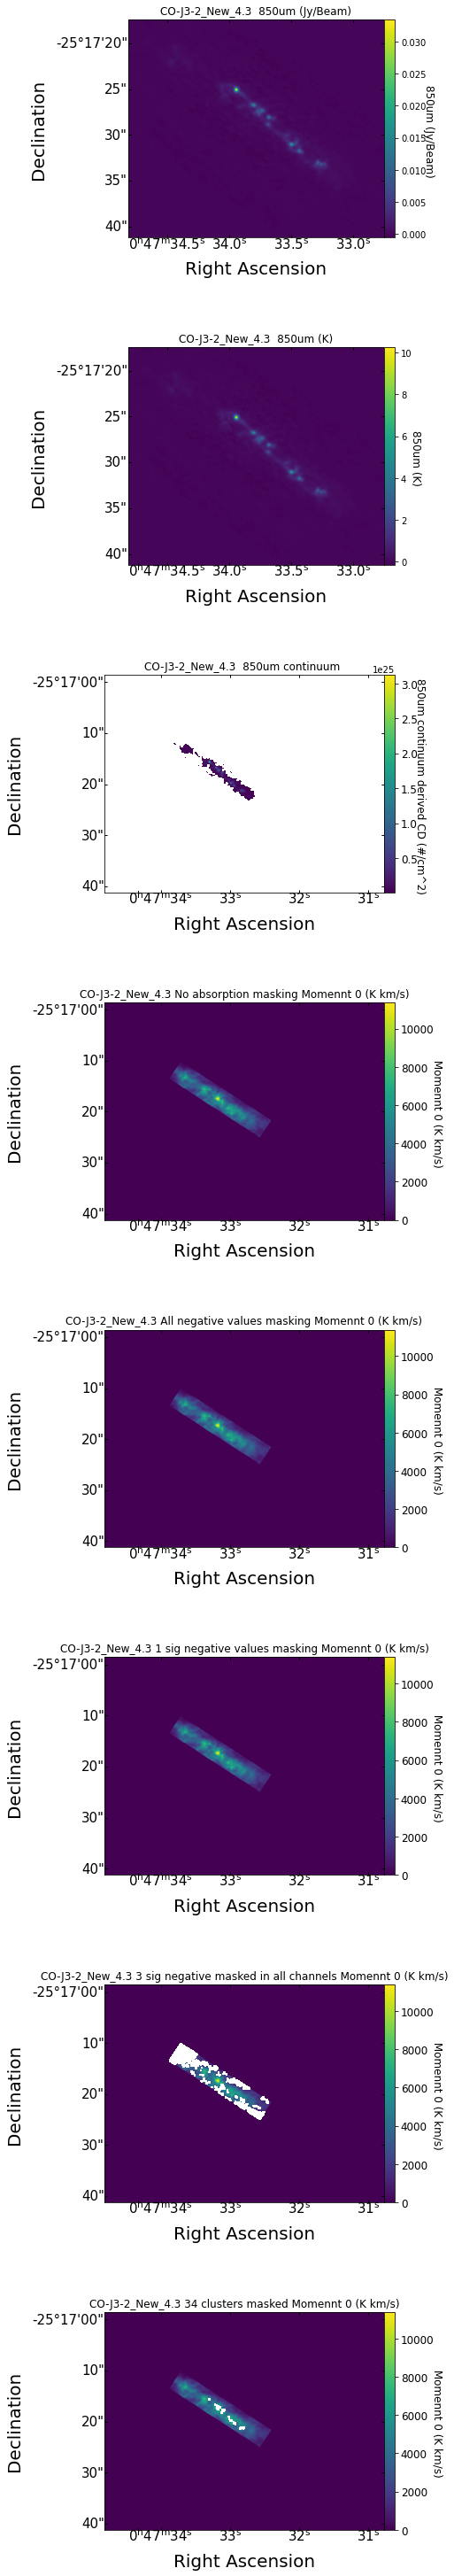

In [5]:

#CO 


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2_New_4.3"
Name = "CO 3-2_Abs_New_4.3"
name = "CO_3_2_CM_Contours_DS_10_Abs_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2


try:
    Names=list(np.load("Names_New.npy"))
except:
    Names=list(np.load("Names.npy"))
Names[Num] = Name


np.save("Names_New",Names)

print(Name)


path ="Cropped_NGC_Spliced_Reprojected_Whole_CO_32_70x360pc_4.3.fits"

pathCont = 'Continuum_Reproject.fits'

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"MPC per pix")

#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()



scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn
datn = dat
#scF = scn[:,400:700,600:360]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
#datn = dat[:,400:700,600:360]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False

#m=.115

#print(m,"Presumed Noise (K)")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


scW = sc.wcs[:][:][0]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 

cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Non_nan=((datn[0,:,:]>0)  | (datn[0,:,:]<0 ))


m = (np.nanstd(datn[0,:,:],where= Non_nan)) #Noise K



fig = plt.figure(1,figsize=(40,40))
for i in range(8):
    datnPrime=np.copy(datn)
    scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
    if(i==3):
        Abs_Level = "No absorption masking"
        scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
        pass
    if(i==4):
        datnPrime[np.where(datn<0)]=np.nan
        scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
        Abs_Level = "All negative values masking"
    if(i==5):
        datnPrime[np.where(datn<-m)]=np.nan
        Abs_Level = "1 sig negative values masking"
        scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
    if(i==6):
        for lmi in range(len(datn)):
            bpP = np.where(datn[lmi]<-3*m)
            for lmj in range(len(datn)):
                datnPrime[lmj][bpP]=np.nan
        Abs_Level = "3 sig negative masked in all channels"
        scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
    if(i==7):
        IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

        datnPrime=  Mask_Clusters_NGC(HWHM,scWCS,scF.hdu.header,datn,RAs,Decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)
        scFPrime = SpectralCube(data=datnPrime,header=scF.header,wcs=scF.wcs)
        Abs_Level = "34 clusters masked"
    Mom0_Data = scFPrime.moment0().hdu.data
    print(m,"Unmatched Noise (K)")


    #Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
    #Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)
    print(i)
    if i ==0:
        Abs_Level = ""
        scContPrime = scCont.to(u.Jy/u.beam)
        ax = pylab.subplot(8,1,i+1,projection=scF.wcs[:][:][0]) 
        RA = ax.coords[0]                                                                  # 
        Dec = ax.coords[1]
        im = pylab.imshow(scContPrime.hdu.data,vmin=np.nanmin(scContPrime.hdu.data),vmax=np.nanmax(scContPrime.hdu.data))
        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
        #cb.set_label(label=LineN+" "+Abs_Level+" 850um (Jy/Beam)",fontsize=12,rotation=260,labelpad=10) 
        cb.set_label(label=" 850um (Jy/Beam)",fontsize=12,rotation=270,labelpad=10) 
        s=LineN+" "+Abs_Level+" 850um (Jy/Beam)"
        ax.set_title(s, fontsize=12)
        cb.ax.tick_params(which = 'major', labelsize = 10)   
        #pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction") 
    elif i ==1:
        Abs_Level = ""
        scContPrime = scCont.to(u.K)
        ax = pylab.subplot(8,1,i+1,projection=scF.wcs[:][:][0]) 
        RA = ax.coords[0]                                                                  # 
        Dec = ax.coords[1]
        im = pylab.imshow(scContPrime.hdu.data,vmin=np.nanmin(scContPrime.hdu.data),vmax=np.nanmax(scContPrime.hdu.data))
        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
        #cb.set_label(label=LineN+" "+Abs_Level+" 850um (K)",fontsize=12,rotation=260,labelpad=10) 
        s=LineN+" "+Abs_Level+" 850um (K)"
        ax.set_title(s, fontsize=12)
        cb.set_label(label=" 850um (K)",fontsize=12,rotation=270,labelpad=10) 
        cb.ax.tick_params(which = 'major', labelsize = 10)   
        #pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction") 
    elif i ==2:
        Abs_Level = ""
        ax = pylab.subplot(8,1,i+1,projection=scF.wcs[:][:][0]) 
        RA = ax.coords[0]                                                                  # 
        Dec = ax.coords[1]
        im = pylab.imshow(cSD,vmin=np.nanmin(cSD*u.cm**2),vmax=np.nanmax(cSD*u.cm**2))
        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
        #cb.set_label(label=LineN+" "+Abs_Level+" 850um continuum derived CD (#/cm^2)",fontsize=12,rotation=260,labelpad=10) 
        s=LineN+" "+Abs_Level+" 850um continuum "
        ax.set_title(s, fontsize=12)
        cb.set_label(label=" 850um continuum derived CD (#/cm^2)",fontsize=12,rotation=270,labelpad=10) 
        cb.ax.tick_params(which = 'major', labelsize = 12)   
        #pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction") 
    else:
        print("L",np.shape(scF.wcs[:][:][0]),np.shape(datnPrime),np.shape(datn))
        ax = pylab.subplot(8,1,i+1,projection=scF.wcs[:][:][0]) 
        RA = ax.coords[0]                                                                  # 
        Dec = ax.coords[1]
        im = pylab.imshow(Mom0_Data,vmin=np.nanmin(scF.moment0().hdu.data),vmax=np.nanmax(scF.moment0().hdu.data))
        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
        #cb.set_label(label=LineN+" "+Abs_Level+" Momennt 0 (K km/s)",fontsize=12,rotation=0,labelpad=10) 
        s=LineN+" "+Abs_Level+" Momennt 0 (K km/s)"
        ax.set_title(s, fontsize=12)
        cb.set_label(label=" Momennt 0 (K km/s)",fontsize=12,rotation=270,labelpad=10) 
        cb.ax.tick_params(which = 'major', labelsize = 12)   
        #pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
plt.tight_layout(h_pad=10)
fig.savefig(bbox_inches='tight',fname="NGC_CO_3_2_4.3_All_abs_Levels.jpeg")
pylab.show()
